Spotify Music Recommendation engine

In [1]:
import numpy as np # use for linear algebra
import pandas as pd # use for data processing on CSV file
import matplotlib.pyplot as plt # for data visualization

Load Spotify Music dataset

In [2]:
df = pd.read_csv("dataset/data.csv") # load datset
df = df.sample(n = 95000, random_state = 42).reset_index(drop = True) # Sample 95000 songs
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978


Features and Scaling

In [3]:
# Select relevant features for Clustering
from sklearn.preprocessing import StandardScaler

numerical_feature = [
  "valence","danceability","energy","tempo",
  "acousticness","liveness","speechiness","instrumentalness"
]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_feature]),columns = numerical_feature)

df_scaled.head() # print

,valence,danceability,energy,tempo,acousticness,liveness,speechiness,instrumentalness
0,1.450620,2.023532,0.143322,0.325014,-0.006224,-0.789165,-0.086645,1.934267
1,0.208104,0.269366,-0.786822,-0.869582,1.136473,-0.446348,-0.114079,-0.164734
2,0.451288,1.932701,0.139587,-0.848751,-0.917724,-0.189236,1.853827,-0.532139
3,-1.262396,-0.423217,-0.730789,2.276645,1.155075,-0.537766,-0.381709,2.141931
4,-0.403654,0.627012,-1.431199,-1.459573,1.309207,-0.537766,0.037111,2.170684


Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

# train model on 80% data and test on 20% data 
train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42) 

Elbow Method plot

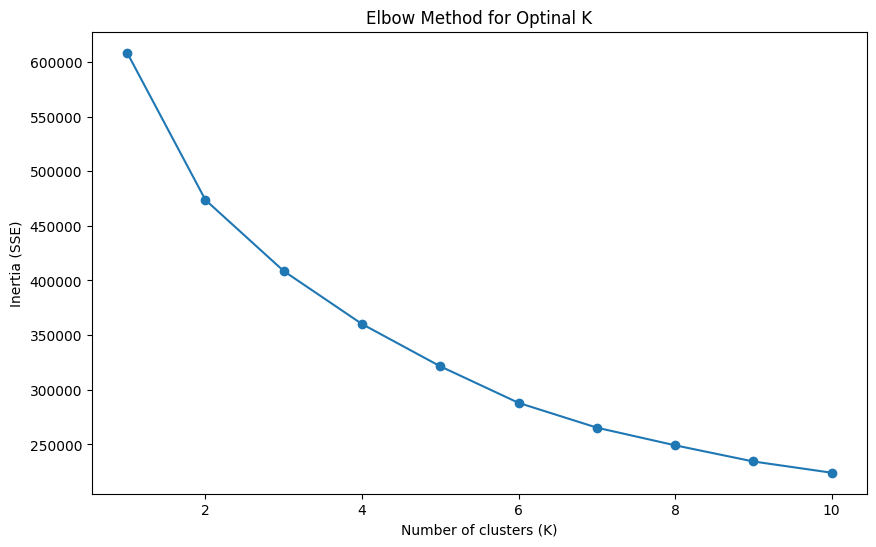

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming train_data is your input dataset
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optinal K")
plt.show()


Applying K-Means Clustering

In [6]:
optinal_k = 5
kmeans = KMeans(n_clusters= k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

df['Cluster'].value_counts()

8    17719
6    13887
1    12744
3    10785
2     9612
4     7704
9     7218
0     6592
7     5653
5     3086
Name: Cluster, dtype: int64

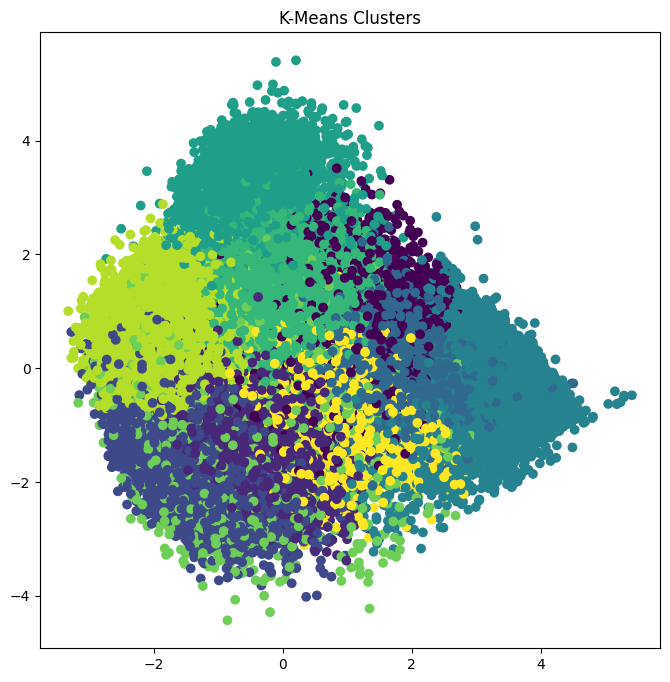

In [7]:
# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

Recommendation System with Kmeans

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df["name"] == song_name]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_features] # type: ignore
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Get top recommendations
    similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations

Recommendation system using KMeans clusters and Cosine similarity

In [9]:
def recommend_songs(input_song, df, num_recommendations=5):
    """
    Recommends songs similar to the input song using cosine similarity within the same cluster.
    Args:
        input_song (str): Title of the input song.
        df (pd.DataFrame): Dataframe containing song titles and features.
        num_recommendations (int): Number of recommendations to return.

    Returns:
        list: A list of recommended songs.
    """
    
    # Check if the input song exists in the dataset
    if input_song not in df['name'].values:
        raise ValueError(f"'{input_song}' not found in the song list.")
    
    # Get the cluster of the input song
    song_cluster = df[df["name"] == input_song]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Get the feature vector of the input song
    input_song_features = same_cluster_songs[same_cluster_songs['name'] == input_song][numerical_feature].values[0]
    
    # Calculate similarity within the cluster
    cluster_features = same_cluster_songs[numerical_feature].values
    similarity = cosine_similarity([input_song_features], cluster_features)[0]

    # Get top recommendations (exclude input song itself)
    similar_songs = np.argsort(similarity)[-num_recommendations-1:-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations

Input song name

In [ ]:
# Input song 
input_song = "Ice Water"


# Get recommended songs
try:
    recommended_songs = recommend_songs(input_song, df, num_recommendations=20)

    # Display results
    print(f"Songs similar to '{input_song}':")
    for i, (name, year, artists) in enumerate(recommended_songs.itertuples(index=False), start=1):
        print(f"{i}. {name} ({year}) - {artists}")
except ValueError as e:
    print(e)

Songs similar to 'Camby Bolongo':
1. Bitch to the Boys (1982) - ['Shakatak']
2. A Fifth Of Beethoven (1977) - ['Walter Murphy']
3. A Fifth Of Beethoven (1977) - ['Walter Murphy']
4. Pocket Calculator - 2009 Remaster (1981) - ['Kraftwerk']
5. Ice Water (1953) - ['Big Jay McNeely']
6. Partido Alto (1979) - ['Azymuth']
7. I'm Getting Sentimental Over You (1965) - ['Herb Alpert & The Tijuana Brass']
8. Dumb (1993) - ['Nirvana']
9. Dumb (1993) - ['Nirvana']
10. Get Thy Bearings (1968) - ['Donovan']
11. Last Night (1961) - ['The Mar-Keys']
12. Linda Guajira (1993) - ['Mongo Santamaria']
13. It's More Fun to Compute - 2009 Remaster (1981) - ['Kraftwerk']
14. Dub Organizer (1973) - ['Augustus Pablo']
15. Rhythm-A-Ning (1963) - ['Thelonious Monk']
16. Rastaman Chant (1973) - ['The Wailers']
17. Twist and Shout (1962) - ["Booker T. & the M.G.'s"]
18. Mandragora (1982) - ['Andreas Vollenweider', 'Walter Keiser', 'Pedro Haldemann', 'Jon Otis']
19. Pa La Paloma (1958) - ['La Sonora Matancera', 'Cel

Save into csv file

In [11]:
df.to_csv("song_df.csv") # csv file for deploying this model